In [ ]:
import requests
import pandas as pd
from tqdm import tqdm

BASE_URL = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/nombre-dassociations-subventionnees-par-la-ville-de-paris-copie/records"
LIMIT_PER_REQUEST = 100
TOTAL_RECORDS = 7842

def fetch_all_records():
    all_records = []
    offset = 0
    
    with tqdm(total=TOTAL_RECORDS, desc="Récupération des données") as pbar:
        while offset < TOTAL_RECORDS:
            params = {
                "limit": LIMIT_PER_REQUEST,
                "offset": offset
            }
            response = requests.get(BASE_URL, params=params)
            if response.status_code == 200:
                batch = response.json().get('results', [])
                all_records.extend(batch)
                offset += len(batch)
                pbar.update(len(batch))
                if len(batch) < LIMIT_PER_REQUEST:
                    break
            else:
                print(f"Erreur à l'offset {offset}: {response.status_code}")
                break
    return all_records

# --- Récupération des données ---
print("Début de l'extraction...")
data = fetch_all_records()
df = pd.DataFrame(data)

# --- Nettoyage et traitement des données ---
# 1. Formatage du montant
if 'montant_vote' in df.columns:
    df['montant_vote'] = (
        df['montant_vote']
        .astype(str)
        .str.replace(r'\s', '', regex=True)
        .str.replace(',', '.')
        .astype(float)
    )

# 2. Conversion de l'année budgétaire
if 'annee_budgetaire' in df.columns:
    df['annee_budgetaire'] = pd.to_numeric(df['annee_budgetaire'], errors='coerce')

# 3. Normalisation du nom du bénéficiaire
if 'nom_beneficiaire' in df.columns:
    df['nom_beneficiaire'] = df['nom_beneficiaire'].str.strip().str.upper()

# 4. Normalisation de la direction
if 'direction' in df.columns:
    df['direction'] = df['direction'].str.strip().str.upper()

# 5. Normalisation du secteur d'activité
col_secteurs = 'secteurs_d_activites_definies_par_l_association'
if col_secteurs in df.columns:
    df[col_secteurs] = df[col_secteurs].str.lower().str.strip()

# 6. Suppression des doublons
cols_doublons = ['numero_siret', 'montant_vote', 'annee_budgetaire']
existing_cols = [col for col in cols_doublons if col in df.columns]
if existing_cols:
    df.drop_duplicates(subset=existing_cols, inplace=True)

# 7. Affichage des valeurs manquantes
print("Valeurs manquantes :")
print(df.isnull().sum())

# 8. Sauvegarde facultative
df.to_csv("subventions_clean_depuis_api.csv", index=False)


Début de l'extraction...


Récupération des données: 100%|██████████| 7842/7842 [00:18<00:00, 427.62it/s]

Valeurs manquantes :
numero_de_dossier                                  2
annee_budgetaire                                   0
nom_beneficiaire                                   0
numero_siret                                       1
objet_du_dossier                                   1
montant_vote                                       0
direction                                          0
nature_de_la_subvention                            0
secteurs_d_activites_definies_par_l_association    0
dtype: int64


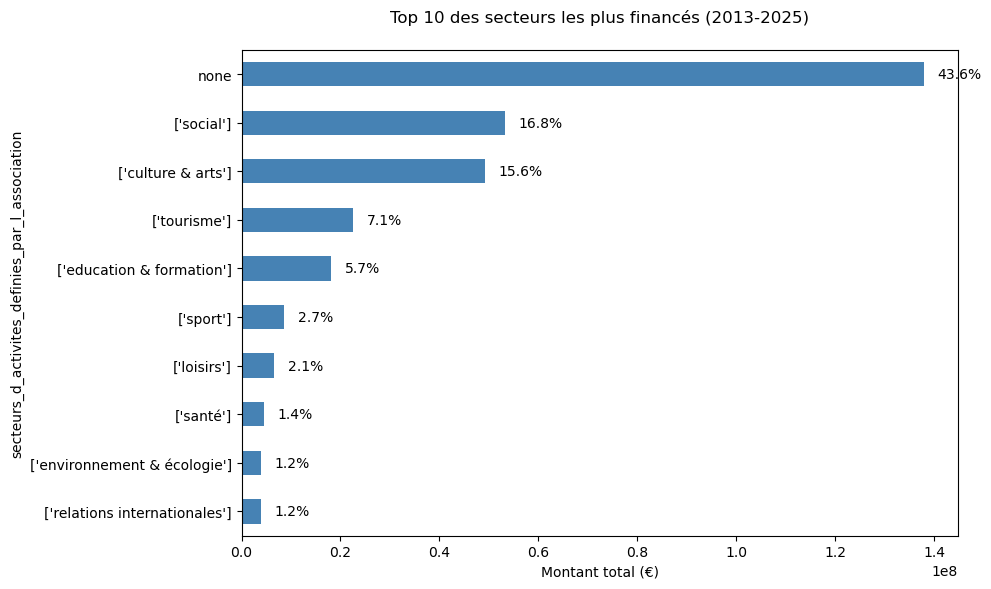

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use('seaborn-v0_8-muted')
os.makedirs("plots", exist_ok=True)

# Optional: Filter by year if the column exists
if 'annee_budgetaire' in df.columns:
    df = df[df['annee_budgetaire'].between(2013, 2025)]

# Check for required columns
if 'secteurs_d_activites_definies_par_l_association' in df.columns and 'montant_vote' in df.columns:
    # Process data
    secteurs = (
        df.groupby('secteurs_d_activites_definies_par_l_association')['montant_vote']
        .sum()
        .sort_values()
        .tail(10)
    )
    total_budget = df['montant_vote'].sum()
    secteurs_pct = (secteurs / total_budget * 100).round(1)

    # Create visualization
    plt.figure(figsize=(10, 6))
    ax = secteurs.plot(kind='barh', color='steelblue')
    plt.title("Top 10 des secteurs les plus financés (2013-2025)", pad=20)
    plt.xlabel("Montant total (€)")
    
    # Add percentage labels
    for i, (val, pct) in enumerate(zip(secteurs, secteurs_pct)):
        ax.text(val + 0.02 * max(secteurs), i, f"{pct}%", va='center')
    
    plt.tight_layout()
    plt.savefig("plots/top_secteurs_avec_pct.png", dpi=300)
    plt.show()
else:
    print("Colonnes manquantes pour effectuer le graphique.")

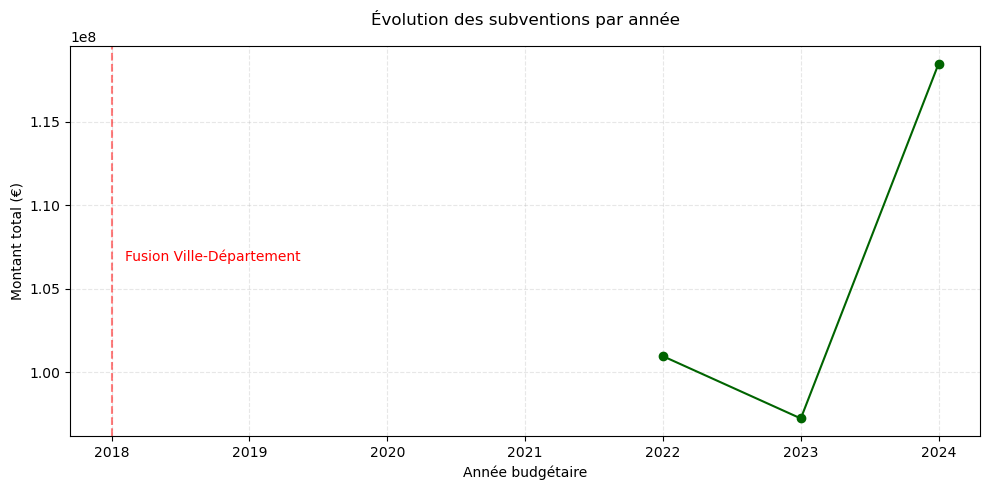

In [14]:
evolution = df.groupby('annee_budgetaire')['montant_vote'].sum()
plt.figure(figsize=(10, 5))
ax = evolution.plot(marker='o', linestyle='-', color='darkgreen')
ax.axvline(x=2018, color='red', linestyle='--', alpha=0.5)
ax.text(2018.1, max(evolution) * 0.9, 'Fusion Ville-Département', color='red')
plt.title("Évolution des subventions par année", pad=15)
plt.xlabel("Année budgétaire")
plt.ylabel("Montant total (€)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("plots/evolution_avec_rupture.png", dpi=300)
plt.show()


C:\Users\bmbar\AppData\Local\Temp\ipykernel_16316\142908234.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


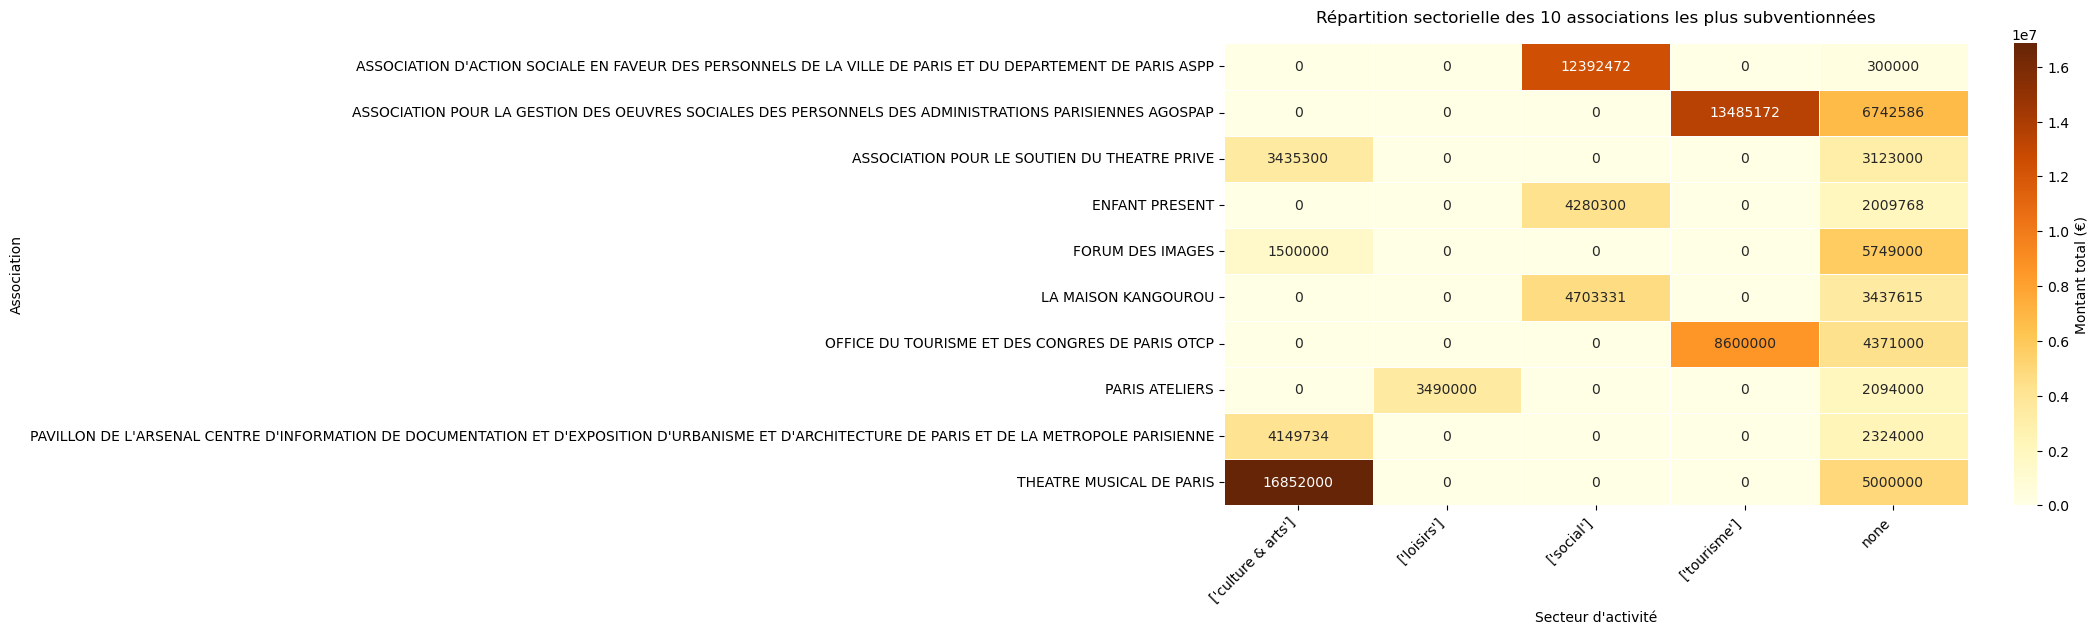

In [11]:
top_assos = df[df['nom_beneficiaire'].isin(
    df.groupby('nom_beneficiaire')['montant_vote'].sum().nlargest(10).index
)]
heatmap_data = top_assos.groupby(['nom_beneficiaire', 'secteurs_d_activites_definies_par_l_association'])['montant_vote'].sum().unstack().fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlOrBr", linewidths=0.5,
            cbar_kws={'label': 'Montant total (€)'})
plt.title("Répartition sectorielle des 10 associations les plus subventionnées", pad=15)
plt.xlabel("Secteur d'activité")
plt.ylabel("Association")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/heatmap_top_assos.png", dpi=300)
plt.show()


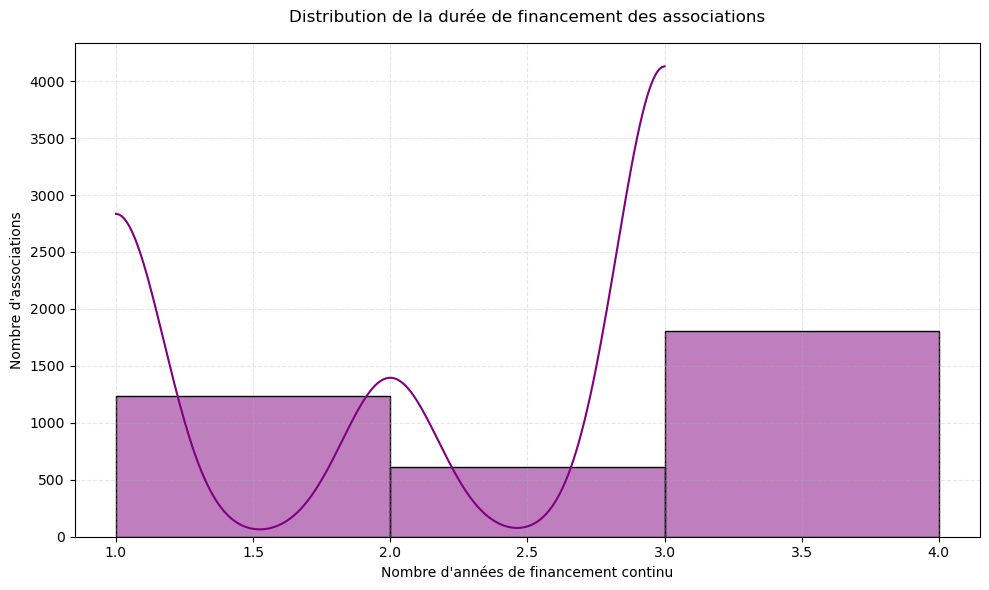

In [15]:
###  📊 Analyses complémentaires : Durée de financement

duree = df.groupby('nom_beneficiaire')['annee_budgetaire'].agg(['min', 'max'])
duree['duree_ans'] = duree['max'] - duree['min'] + 1

plt.figure(figsize=(10, 6))
sns.histplot(data=duree, x='duree_ans', bins=range(1, duree['duree_ans'].max()+2),
             kde=True, color='purple')
plt.title("Distribution de la durée de financement des associations", pad=15)
plt.xlabel("Nombre d'années de financement continu")
plt.ylabel("Nombre d'associations")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("plots/duree_financement.png", dpi=300)
plt.show()
